# Análise Completa do Dataset Titanic (titanic3.csv)
Notebook adaptado a partir do script em Python.

Autor: Gerado por ChatGPT (para Evandro de Castro Melo)

Este notebook cobre:
1. Carregamento e inspeção dos dados
2. Tratamento de dados faltantes
3. Análise Exploratória (estatísticas e gráficos)
4. Engenharia de atributos
5. Modelagem preditiva (Regressão Logística)
6. Publicação dos resultados em células e também em arquivos (PNG, CSV, TXT)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

plt.rcParams['figure.figsize'] = (6,4)

def ensure_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path)


## 1. Carregar dados

In [2]:
arquivo_csv = "dados_titanic.csv"  # deve estar na mesma pasta que o notebook
figdir = "figures"
relatorio = "resumo_analise.txt"
csv_limpo = "titanic3_clean.csv"

df = pd.read_csv(arquivo_csv)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## 2. Dados faltantes e estatísticas

In [3]:
faltantes = pd.DataFrame({
    "faltantes": df.isna().sum(),
    "percentual": (df.isna().sum()/len(df)*100).round(2)
}).sort_values("percentual", ascending=False)
faltantes.head(20)

,faltantes,percentual
body,1188,90.76
cabin,1014,77.46
boat,823,62.87
home.dest,564,43.09
age,263,20.09
embarked,2,0.15
fare,1,0.08
sibsp,0,0.00
name,0,0.00
survived,0,0.00


In [4]:
df.describe(percentiles=[.05,.25,.5,.75,.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
pclass,1309.0,2.294882,0.837836,1.00,1.000,2.0000,3.0000,3.000,3.00,3.0000
survived,1309.0,0.381971,0.486055,0.00,0.000,0.0000,0.0000,1.000,1.00,1.0000
age,1046.0,29.881138,14.413493,0.17,5.000,21.0000,28.0000,39.000,57.00,80.0000
sibsp,1309.0,0.498854,1.041658,0.00,0.000,0.0000,0.0000,1.000,2.00,8.0000
parch,1309.0,0.385027,0.865560,0.00,0.000,0.0000,0.0000,0.000,2.00,9.0000
fare,1308.0,33.295479,51.758668,0.00,7.225,7.8958,14.4542,31.275,133.65,512.3292
body,121.0,160.809917,97.696922,1.00,16.000,72.0000,155.0000,256.000,307.00,328.0000


## 3. Tratamento de dados

In [5]:
dfc = df.copy()

if "home.dest" in dfc.columns and "home_dest" not in dfc.columns:
    dfc = dfc.rename(columns={"home.dest": "home_dest"})

for col in ["sex", "embarked"]:
    if col in dfc.columns:
        moda = dfc[col].mode(dropna=True)
        if len(moda) > 0:
            dfc[col] = dfc[col].fillna(moda.iloc[0])

for col in ["age", "fare"]:
    if col in dfc.columns:
        dfc[col] = dfc[col].fillna(dfc[col].median())

for col in ["cabin", "boat", "home_dest", "ticket", "name"]:
    if col in dfc.columns:
        dfc[f"has_{col}"] = (~dfc[col].isna()).astype(int)

if "name" in dfc.columns:
    dfc["title"] = (
        dfc["name"]
        .astype(str)
        .str.extract(r",\s*([^\.]+)\.", expand=False)  # CORRIGIDO
        .str.strip()
    )
    raros = dfc["title"].value_counts()[lambda x: x < 10].index
    dfc["title"] = dfc["title"].apply(lambda x: "Rare" if x in raros else x)

if set(["sibsp", "parch"]).issubset(dfc.columns):
    dfc["family_size"] = dfc["sibsp"].fillna(0) + dfc["parch"].fillna(0) + 1
    dfc["is_alone"] = (dfc["family_size"] == 1).astype(int)

dfc.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,body,home_dest,has_cabin,has_boat,has_home_dest,has_ticket,has_name,title,family_size,is_alone
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,...,NaN,"St Louis, MO",1,1,1,1,1,Miss,1,1
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,1,1,1,1,Master,4,0
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,0,1,1,1,Miss,4,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,...,135.0,"Montreal, PQ / Chesterville, ON",1,0,1,1,1,Mr,4,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,0,1,1,1,Mrs,4,0


## 4. Gráficos exploratórios

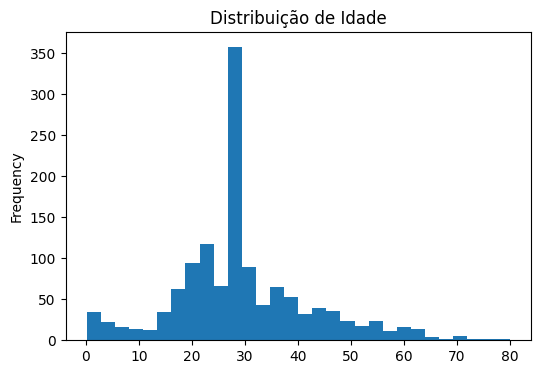

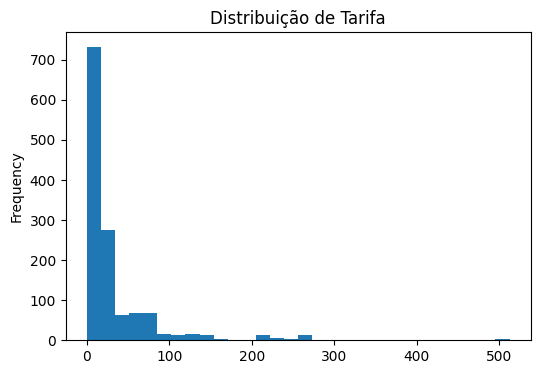

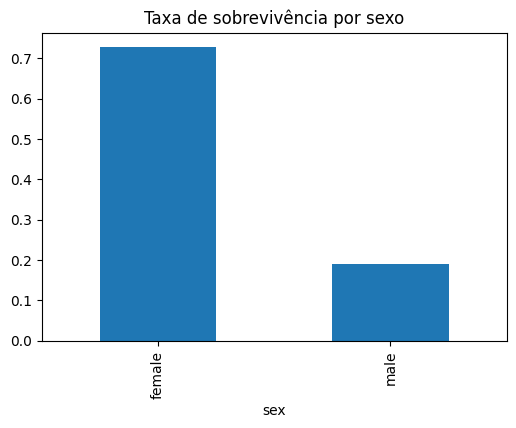

In [6]:
ensure_dir(figdir)

if "age" in dfc.columns:
    dfc["age"].dropna().plot(kind="hist", bins=30, title="Distribuição de Idade")
    plt.show()

if "fare" in dfc.columns:
    dfc["fare"].dropna().plot(kind="hist", bins=30, title="Distribuição de Tarifa")
    plt.show()

if set(["survived","sex"]).issubset(dfc.columns):
    taxa = dfc.groupby("sex")["survived"].mean()
    taxa.plot(kind="bar", title="Taxa de sobrevivência por sexo")
    plt.show()


## 5. Preparar modelagem

In [7]:
y = dfc["survived"].astype(int)
possiveis = ["pclass","sex","age","sibsp","parch","fare","embarked",
             "family_size","is_alone","title",
             "has_cabin","has_boat","has_home_dest","has_ticket","has_name"]
cols = [c for c in possiveis if c in dfc.columns]
X = dfc[cols].copy()
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)
X.head()

,pclass,age,sibsp,parch,fare,family_size,is_alone,has_cabin,has_boat,has_home_dest,has_ticket,has_name,sex_male,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,-1.546098,-0.039006,-0.479087,-0.445000,3.442584,-0.558346,0.810532,1.853992,1.301313,0.870084,0.0,0.0,-1.344995,-0.32204,0.655011,2.008635,-1.171058,-0.420902,-0.163299
1,-1.546098,-2.215698,0.481288,1.866526,2.286639,1.336749,-1.233758,1.853992,1.301313,0.870084,0.0,0.0,0.743497,-0.32204,0.655011,-0.497850,-1.171058,-0.420902,-0.163299
2,-1.546098,-2.131979,0.481288,1.866526,2.286639,1.336749,-1.233758,1.853992,-0.768455,0.870084,0.0,0.0,-1.344995,-0.32204,0.655011,2.008635,-1.171058,-0.420902,-0.163299
3,-1.546098,0.038512,0.481288,1.866526,2.286639,1.336749,-1.233758,1.853992,-0.768455,0.870084,0.0,0.0,0.743497,-0.32204,0.655011,-0.497850,0.853929,-0.420902,-0.163299
4,-1.546098,-0.349076,0.481288,1.866526,2.286639,1.336749,-1.233758,1.853992,-0.768455,0.870084,0.0,0.0,-1.344995,-0.32204,0.655011,-0.497850,-1.171058,2.375851,-0.163299


## 6. Treinar e avaliar modelo

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_proba)
print(f"Acurácia: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}\n")
print(classification_report(y_test,y_pred))

Acurácia: 0.9665
ROC AUC: 0.9905

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       203
           1       0.97      0.94      0.96       125

    accuracy                           0.97       328
   macro avg       0.97      0.96      0.96       328
weighted avg       0.97      0.97      0.97       328



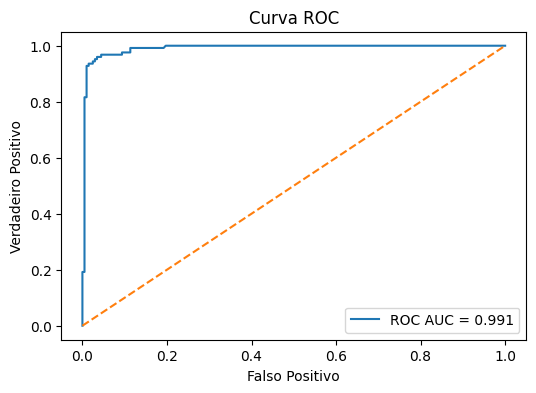

In [9]:
fpr, tpr, _ = roc_curve(y_test,y_proba)
plt.plot(fpr,tpr,label=f"ROC AUC = {auc:.3f}")
plt.plot([0,1],[0,1],linestyle="--")
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.show()


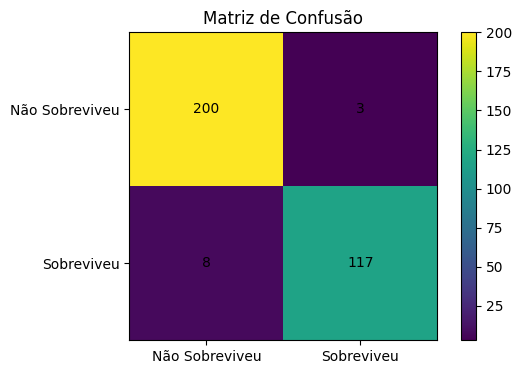

In [10]:
cm = confusion_matrix(y_test,y_pred)
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusão")
plt.colorbar()
plt.xticks([0,1],["Não Sobreviveu","Sobreviveu"])
plt.yticks([0,1],["Não Sobreviveu","Sobreviveu"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.show()


## 7. Salvar arquivos de saída

In [11]:
dfc.to_csv(csv_limpo,index=False,encoding="utf-8")
pd.Series(clf.coef_[0],index=X.columns).to_csv("coeficientes_logistica.csv")
with open(relatorio,"w",encoding="utf-8") as f:
    f.write(f"Acurácia: {acc:.4f}\nROC AUC: {auc:.4f}\n")
print("Arquivos salvos:")
print("-", csv_limpo)
print("- coeficientes_logistica.csv")
print("-", relatorio)


Arquivos salvos:
- titanic3_clean.csv
- coeficientes_logistica.csv
- resumo_analise.txt
